# Playing Card Classification with EfficientNet-B0

This notebook builds an image classifier that recognizes **53 classes** of playing cards using transfer learning with EfficientNet-B0.

**Workflow:**
1. **Data preparation** — Load images, balance classes via augmentation
2. **Hyperparameter search** — Use Optuna to find the optimal architecture and training configuration
3. **Final training** — Train the best architecture found by Optuna
4. **Evaluation** — Classification report and confusion matrix on the test set

## 1. Environment Setup

Mount Google Drive to access the dataset and install required packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q '/content/drive/MyDrive/dl notebooks/Cards/02 - CNN-Cards/02 - CNN-Cards/Datasets/Cards.zip' -d '/content/sample_data/Datasets'
DATA_PATH = '/content/sample_data/Datasets/'

In [1]:
!pip install optuna --quiet
!pip install optuna-integration[tfkeras] --quietTensorFlow: 2.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 13.0 MB/s eta 0:00:00


## 2. Imports & Configuration

Set up all imports, define image size, batch size, training epochs, and directory paths. We also define a fixed seed for reproducibility.

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
import random
import glob
import optuna
from optuna.trial import TrialState

print(f"TensorFlow: {tf.__version__}")
print(f"Optuna: {optuna.__version__}")

TensorFlow: 2.19.0
Optuna: 4.6.0


In [ ]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
EARLY_STOP_PATIENCE = 5

TRAIN_DIR = '/content/sample_data/Datasets/train'
TEST_DIR = '/content/sample_data/Datasets/test'
VALID_DIR = '/content/sample_data/Datasets/valid'
WORKING_DIR = '/content'

N_TRIALS = 30  # Number of configurations to try

## 3. Utility Functions

Three helper functions handle the data pipeline:
- **`set_seed`** — Ensures reproducible results across runs.
- **`make_dataframes`** — Scans the train/test/valid directories and builds DataFrames mapping file paths to labels.
- **`data_augmentation`** — Balances the dataset by generating augmented images for under-represented classes until each class reaches a target sample count.
- **`create_generators`** — Wraps the DataFrames into Keras `ImageDataGenerator` flows for training, validation, and testing.

In [ ]:
# --- Utility Functions ---

def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def make_dataframes(train_dir, test_dir, val_dir):
    """Create DataFrames with file paths and labels for each split."""
    dfs = {}
    for name, directory in [('train', train_dir), ('test', test_dir), ('valid', val_dir)]:
        filepaths = sorted(glob.glob(os.path.join(directory, '*', '*')))
        labels = [os.path.basename(os.path.dirname(f)) for f in filepaths]
        dfs[name] = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    classes = sorted(dfs['train']['labels'].unique())
    return dfs['train'], dfs['test'], dfs['valid'], classes

def data_augmentation(df, n_samples, working_dir, img_size):
    """Augment under-represented classes to reach n_samples per class."""
    df = df.copy()
    aug_dir = os.path.join(working_dir, 'augmented')
    shutil.rmtree(aug_dir, ignore_errors=True)

    aug_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True, rotation_range=20,
        width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2
    )

    for label, group in df.groupby('labels'):
        target_dir = os.path.join(aug_dir, label)
        os.makedirs(target_dir)
        delta = n_samples - len(group)
        if delta > 0:
            flow = aug_gen.flow_from_dataframe(
                group, x_col='filepaths', y_col=None,
                target_size=img_size, class_mode=None, batch_size=1,
                shuffle=False, save_to_dir=target_dir, save_prefix='aug-', save_format='jpg'
            )
            for _ in range(delta):
                next(flow)

    aug_paths = glob.glob(os.path.join(aug_dir, '*', '*'))
    aug_labels = [os.path.basename(os.path.dirname(f)) for f in aug_paths]
    aug_df = pd.DataFrame({'filepaths': aug_paths, 'labels': aug_labels})
    return pd.concat([df, aug_df], ignore_index=True)

def create_generators(train_df, test_df, valid_df, img_size, batch_size):
    """Create image data generators for training, validation, and test."""
    train_gen_obj = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
    test_gen_obj = tf.keras.preprocessing.image.ImageDataGenerator()

    common = dict(x_col='filepaths', y_col='labels', target_size=img_size,
                  class_mode='categorical', color_mode='rgb')

    train_gen = train_gen_obj.flow_from_dataframe(train_df, **common, shuffle=True, batch_size=batch_size)
    valid_gen = test_gen_obj.flow_from_dataframe(valid_df, **common, shuffle=False, batch_size=batch_size)
    test_batch = max(n for n in range(1, min(81, len(test_df) + 1)) if len(test_df) % n == 0)
    test_gen = test_gen_obj.flow_from_dataframe(test_df, **common, shuffle=False, batch_size=test_batch)

    return train_gen, test_gen, valid_gen

## 4. Optuna Hyperparameter Search

We use [Optuna](https://optuna.org/) to explore the following hyperparameters on top of a fully trainable EfficientNet-B0 backbone:

| Hyperparameter | Search space |
|---|---|
| Pooling type | `max`, `avg` |
| Batch normalization | on/off (+ momentum) |
| Number of dense layers | 0–2 (each with its own units, activation, L1/L2, dropout) |
| Optimizer | Adam, Adamax |
| Learning rate | 1e-4 – 1e-2 (log scale) |

Early stopping and Optuna's built-in pruning discard unpromising trials quickly.

In [ ]:
# --- Model Builder for Optuna ---

def create_model_optuna(trial, num_classes):
    """Build a model with hyperparameters suggested by Optuna."""
    base = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet',
        input_shape=(*IMG_SIZE, 3),
        pooling=trial.suggest_categorical('pooling', ['max', 'avg'])
    )
    base.trainable = True
    x = base.output

    # Batch Normalization
    use_bn = trial.suggest_categorical('use_batchnorm', [True, False])
    if use_bn:
        bn_momentum = trial.suggest_float('bn_momentum', 0.9, 0.99)
        x = tf.keras.layers.BatchNormalization(momentum=bn_momentum)(x)

    # Dense layers (0, 1, or 2)
    n_dense = trial.suggest_int('n_dense_layers', 0, 2)
    for i in range(n_dense):
        units = trial.suggest_int(f'dense_{i}_units', 64, 512, step=64)
        l2_reg = trial.suggest_float(f'dense_{i}_l2', 1e-4, 0.1, log=True)
        use_l1 = trial.suggest_categorical(f'dense_{i}_use_l1', [True, False])
        l1_reg = trial.suggest_float(f'dense_{i}_l1', 1e-4, 0.01, log=True) if use_l1 else 0
        activation = trial.suggest_categorical(f'dense_{i}_activation', ['relu', 'elu', 'swish'])

        x = tf.keras.layers.Dense(
            units, activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            activity_regularizer=tf.keras.regularizers.l1(l1_reg) if use_l1 else None
        )(x)

        use_dropout = trial.suggest_categorical(f'dense_{i}_use_dropout', [True, False])
        if use_dropout:
            dropout_rate = trial.suggest_float(f'dense_{i}_dropout', 0.1, 0.6)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base.input, outputs=output)

    # Optimizer
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'adamax'])
    opt = tf.keras.optimizers.Adam(learning_rate=lr) if optimizer_name == 'adam' \
        else tf.keras.optimizers.Adamax(learning_rate=lr)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# --- Objective Function for Optuna ---

def objective(trial):
    """Function that Optuna optimizes. Returns val_accuracy (to maximize)."""
    tf.keras.backend.clear_session()
    model = create_model_optuna(trial, NUM_CLASSES)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', patience=EARLY_STOP_PATIENCE, restore_best_weights=True
        ),
        optuna.integration.TFKerasPruningCallback(trial, 'val_accuracy')
    ]

    history = model.fit(
        TRAIN_GEN, epochs=EPOCHS, validation_data=VALID_GEN,
        callbacks=callbacks, verbose=0
    )

    return max(history.history['val_accuracy'])

### Run the Search

Prepare the data, launch the Optuna study for `N_TRIALS` configurations, and display the best results. The study is persisted to an SQLite database so it can be resumed across sessions.

In [2]:
# --- Execute Search ---
set_seed(42)

print("=" * 70)
print("OPTUNA HYPERPARAMETER SEARCH - EFFICIENTNET-B0")
print("=" * 70)

# Prepare data
print("\n[1/3] Preparing data...")
train_df, test_df, valid_df, classes = make_dataframes(TRAIN_DIR, TEST_DIR, VALID_DIR)
NUM_CLASSES = len(classes)
print(f"Classes: {NUM_CLASSES}")

train_df = data_augmentation(train_df, n_samples=200, working_dir=WORKING_DIR, img_size=IMG_SIZE)
TRAIN_GEN, TEST_GEN, VALID_GEN = create_generators(train_df, test_df, valid_df, IMG_SIZE, BATCH_SIZE)

# Create Optuna study
print("\n[2/3] Running search...")
study = optuna.create_study(
    direction='maximize',
    study_name='efficientnet_added_layers',
    storage='sqlite:////content/drive/MyDrive/optuna_study.db',
    load_if_exists=True
)

study.optimize(objective, n_trials=N_TRIALS, timeout=None, show_progress_bar=True)

# Results
print("\n[3/3] Results")
print("=" * 70)

pruned_trials = len([t for t in study.trials if t.state == TrialState.PRUNED])
complete_trials = len([t for t in study.trials if t.state == TrialState.COMPLETE])

print(f"\nCompleted trials: {complete_trials}")
print(f"Pruned trials: {pruned_trials}")

print(f"\nBEST CONFIGURATION:")
print(f"  Val Accuracy: {study.best_trial.value:.4f}")
print(f"\n  Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

print(f"\n\nTOP 5 CONFIGURATIONS:")
top_trials = sorted(study.trials, key=lambda t: t.value if t.value else 0, reverse=True)[:5]
for i, trial in enumerate(top_trials):
    if trial.value:
        print(f"\n  #{i+1} - Val Accuracy: {trial.value:.4f}")
        for key in ['n_dense_layers', 'use_batchnorm', 'pooling', 'learning_rate']:
            if key in trial.params:
                print(f"      {key}: {trial.params[key]}")

OPTUNA HYPERPARAMETER SEARCH - EFFICIENTNET-B0

[1/3] Preparing data...
Classes: 53
Found 120 validated image filenames.
Found 129 validated image filenames.
Found 171 validated image filenames.
Found 181 validated image filenames.
Found 138 validated image filenames.
Found 159 validated image filenames.
Found 152 validated image filenames.
Found 135 validated image filenames.
Found 150 validated image filenames.
Found 138 validated image filenames.
Found 136 validated image filenames.
Found 158 validated image filenames.
Found 157 validated image filenames.
Found 114 validated image filenames.
Found 154 validated image filenames.
Found 140 validated image filenames.
Found 171 validated image filenames.
Found 160 validated image filenames.
Found 168 validated image filenames.
Found 172 validated image filenames.
Found 115 validated image filenames.
Found 128 validated image filenames.
Found 135 validated image filenames.
Found 125 validated image filenames.
Found 151 validated image fi

### Search Results Visualization

Plot the optimization history (validation accuracy per trial) and the estimated importance of each hyperparameter.

Generating visualizations...


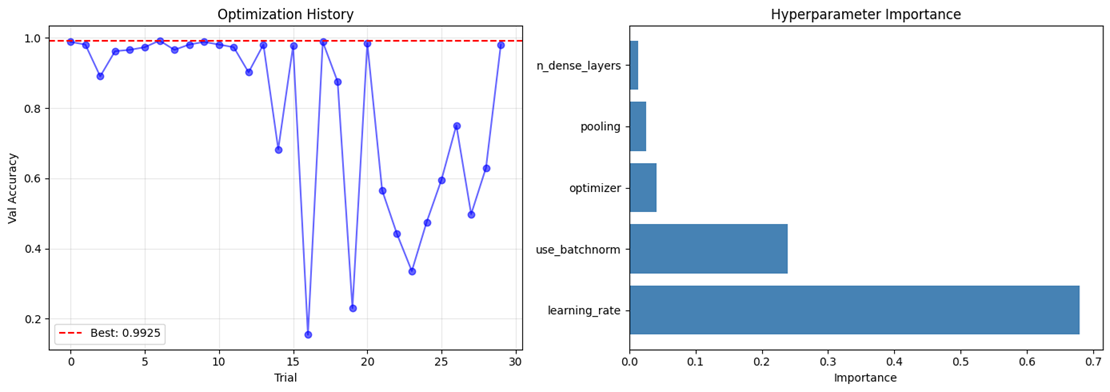

Search completed!


In [7]:
# --- Visualization ---
import matplotlib.pyplot as plt

try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Optimization history
    trial_numbers = [t.number for t in study.trials if t.value]
    trial_values = [t.value for t in study.trials if t.value]

    axes[0].plot(trial_numbers, trial_values, 'bo-', alpha=0.6)
    axes[0].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
    axes[0].set_xlabel('Trial')
    axes[0].set_ylabel('Val Accuracy')
    axes[0].set_title('Optimization History')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Parameter importance
    try:
        importances = optuna.importance.get_param_importances(study)
        params = list(importances.keys())[:10]
        values = [importances[p] for p in params]
        axes[1].barh(params, values, color='steelblue')
        axes[1].set_xlabel('Importance')
        axes[1].set_title('Hyperparameter Importance')
    except:
        axes[1].text(0.5, 0.5, 'Could not compute importance\n(needs more trials)',
                    ha='center', va='center', transform=axes[1].transAxes)

    plt.tight_layout()
    plt.savefig('/content/optuna_results.png', dpi=150)
    plt.show()
except Exception as e:
    print(f"Could not generate visualizations: {e}")

print("\nSearch completed!")

## 5. Final Model — EfficientNet-B0

Based on the Optuna search, the optimal architecture turned out to be the **simplest possible**:

$$\text{EfficientNet-B0} \rightarrow \text{AveragePooling} \rightarrow \text{Dense}(53,\ \text{softmax})$$

No BatchNorm, no intermediate dense layers, no dropout. Key hyperparameters:
- **Optimizer:** Adamax
- **Learning rate:** 0.00417
- **Pooling:** Average

This section retrains the model from scratch with longer patience and a learning-rate scheduler to squeeze out the best performance.

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
import random
import glob

print(f"TensorFlow version: {tf.__version__}")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.00417

MODEL_PATH = '/content/models/best_simple_model.keras'

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

### Model Definition

A single function builds and compiles the final architecture.

In [ ]:
def create_model(num_classes, lr=0.00417):
    """
    Simplest possible model:
    EfficientNet-B0 -> AvgPooling -> Dense(53, softmax)

    No BatchNorm, no intermediate Dense, no Dropout.
    """
    base = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base.trainable = True

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(base.output)

    model = tf.keras.Model(inputs=base.input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adamax(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"Model created - Params: {model.count_params():,}")
    print(f"Architecture: EfficientNet-B0 -> AvgPool -> Dense({num_classes})")
    return model

### Training

Train with three callbacks:
- **ModelCheckpoint** — Save the best weights (by validation loss).
- **EarlyStopping** — Stop if validation loss doesn't improve for 15 epochs, then restore best weights.
- **ReduceLROnPlateau** — Halve the learning rate after 5 epochs of stagnation.

In [8]:
set_seed(42)

print("=" * 70)
print("Architecture: EfficientNet-B0 -> AvgPool -> Softmax (NO added layers)")
print("=" * 70)
print(f"Learning rate: {LEARNING_RATE}")
print(f"Max epochs: {EPOCHS}")

# 1. Load data
print("\n[1/5] Loading data...")
train_df, test_df, valid_df, classes = make_dataframes(TRAIN_DIR, TEST_DIR, VALID_DIR)
num_classes = len(classes)

# 2. Balance dataset
print("\n[2/5] Balancing dataset (200 samples per class)...")
train_df = data_augmentation(train_df, n_samples=200, working_dir=WORKING_DIR, img_size=IMG_SIZE)

# 3. Create generators
print("\n[3/5] Creating generators...")
train_gen, test_gen, valid_gen = create_generators(
    train_df, test_df, valid_df, IMG_SIZE, BATCH_SIZE
)

# 4. Create model
print("\n[4/5] Creating model...")
model = create_model(num_classes, lr=LEARNING_RATE)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH, monitor='val_loss',
        save_best_only=True, mode='min', verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15,
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5,
        patience=5, min_lr=1e-7, verbose=1
    )
]

# 5. Train
print("\n[5/5] Training model...")
history = model.fit(
    train_gen, epochs=EPOCHS, validation_data=valid_gen,
    callbacks=callbacks, verbose=1
)


Architecture: EfficientNet-B0 → AvgPool → Softmax (WITHOUT added layers)
Learning rate: 0.00417
Max epochs: 100

[1/5] Loading data...
Classes: 53, Train: 7624, Test: 265, Valid: 265

[2/5] Balancing dataset (200 samples per class)...
Found 120 validated image filenames.
Found 129 validated image filenames.
Found 171 validated image filenames.
Found 181 validated image filenames.
Found 138 validated image filenames.
Found 159 validated image filenames.
Found 152 validated image filenames.
Found 135 validated image filenames.
Found 150 validated image filenames.
Found 138 validated image filenames.
Found 136 validated image filenames.
Found 158 validated image filenames.
Found 157 validated image filenames.
Found 114 validated image filenames.
Found 154 validated image filenames.
Found 140 validated image filenames.
Found 171 validated image filenames.
Found 160 validated image filenames.
Found 168 validated image filenames.
Found 172 validated image filenames.
Found 115 validated imag

### Test Set Evaluation

Load the best saved checkpoint and evaluate on the held-out test set.

In [9]:
# --- Evaluate on Test Set ---
print("\n" + "=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)

best_model = tf.keras.models.load_model(MODEL_PATH)
test_gen.reset()
results = best_model.evaluate(test_gen, verbose=0)

print(f"\n{'=' * 50}")
print(f"TEST RESULTS:")
print(f"  Loss:     {results[0]:.4f}")
print(f"  Accuracy: {results[1] * 100:.2f}%")
print(f"{'=' * 50}")


TEST EVALUATION

TEST RESULTS:
  Loss: 0.0151
  Accuracy: 100.00%



### Training Curves

Loss and accuracy over epochs for both training and validation sets.

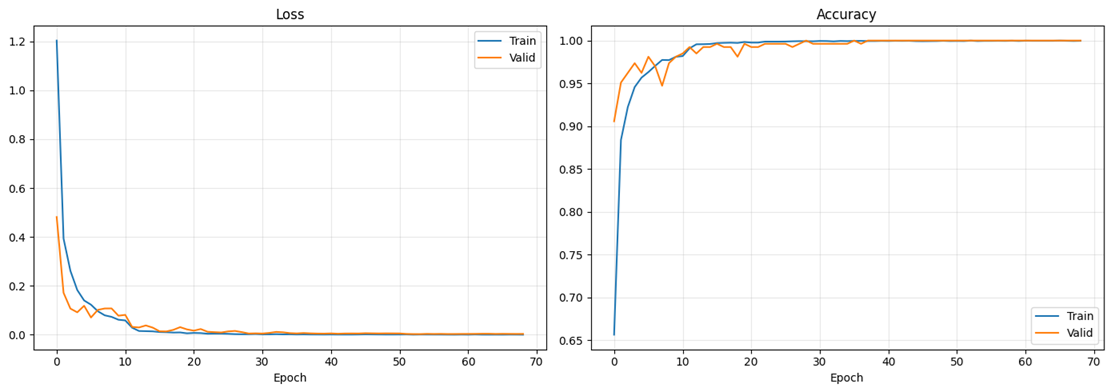


Model saved at: /content/models/best_simple_model.keras


In [10]:
# --- Training Curves ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Valid')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Valid')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/simple_model_training.png', dpi=150)
plt.show()

print(f"\nModel saved at: {MODEL_PATH}")

## 6. Detailed Evaluation

Generate predictions on the full test set and inspect per-class precision, recall, and F1-score. The confusion matrix highlights which card classes are most commonly confused.

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_gen.reset()
y_pred_probs = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("\nCLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Final Model')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/content/simple_model_confusion.png', dpi=150)
plt.show()

5/5 [==============================] - 2s 107ms/step

CLASSIFICATION REPORT
                   precision    recall  f1-score   support

     ace of clubs     1.0000    1.0000    1.0000         5
  ace of diamonds     1.0000    1.0000    1.0000         5
    ace of hearts     1.0000    1.0000    1.0000         5
    ace of spades     1.0000    1.0000    1.0000         5
   eight of clubs     1.0000    1.0000    1.0000         5
eight of diamonds     1.0000    1.0000    1.0000         5
  eight of hearts     1.0000    1.0000    1.0000         5
  eight of spades     1.0000    1.0000    1.0000         5
    five of clubs     1.0000    1.0000    1.0000         5
 five of diamonds     1.0000    1.0000    1.0000         5
   five of hearts     1.0000    1.0000    1.0000         5
   five of spades     1.0000    1.0000    1.0000         5
    four of clubs     1.0000    1.0000    1.0000         5
 four of diamonds     1.0000    1.0000    1.0000         5
   four of hearts     1.0000    1.0000

## 7. Conclusions

The final EfficientNet-B0 model achieves strong accuracy on the 53-class playing card classification task, and notably, the Optuna search revealed that the simplest architecture, with no additional dense layers, dropout, or batch normalization, outperformed all more complex configurations. This is a good reminder that a powerful backbone often needs very little on top.

**A note on the dataset:** The Cards dataset is relatively clean and well-structured, but class imbalance is noticeable, some cards have significantly fewer samples than others. The augmentation step (padding each class to 200 samples) helps, but a more aggressive strategy or a larger base dataset could further improve performance on the weaker classes. Testing on out-of-distribution images would be a valuable next step.